
## <center>L'objectif de ce TP 4 est de créer les fonctions principales pour entraîner un réseau de neurones en utilisant NumPy (from scratch).</center>

L'objectif est de classifier des points 2D en **K = 5 classes**. Comme ces classes ne sont pas linéairement séparables, nous pouvons résoudre ce problème en utilisant un **réseau de neurones MLP** et un ensemble de données composé de 400 exemples d'entraînement et de 100 exemples de test. Chaque exemple est donné sous forme (x, y), où x est l'entrée et y est la sortie désirée.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.metrics import accuracy_score

Nous allons importer les données du problème de classification à partir d'un fichier .npz, puis les préparer pour entraîner un réseau de neurones MLP avec une seule couche cachée.

In [6]:
from sklearn.preprocessing import OneHotEncoder

File = 'data.npz'

with np.load(File) as data_set:
    X_train = data_set['x_train'].T
    y_train = data_set['y_train']
    X_test = data_set['x_test'].T
    y_test = data_set['y_test']

encoder = OneHotEncoder(sparse_output=False, categories='auto')

Y_train = encoder.fit_transform(y_train.reshape(-1, 1)).T
Y_test = encoder.fit_transform(y_test.reshape(-1, 1)).T

print(f'X_train.shape = {X_train.shape}   et   Y_train.shape = {Y_train.shape}')
print(f'X_test.shape = {X_test.shape}   et   Y_test.shape = {Y_test.shape}')

X_train.shape = (2, 400)   et   Y_train.shape = (5, 400)
X_test.shape = (2, 100)   et   Y_test.shape = (5, 100)


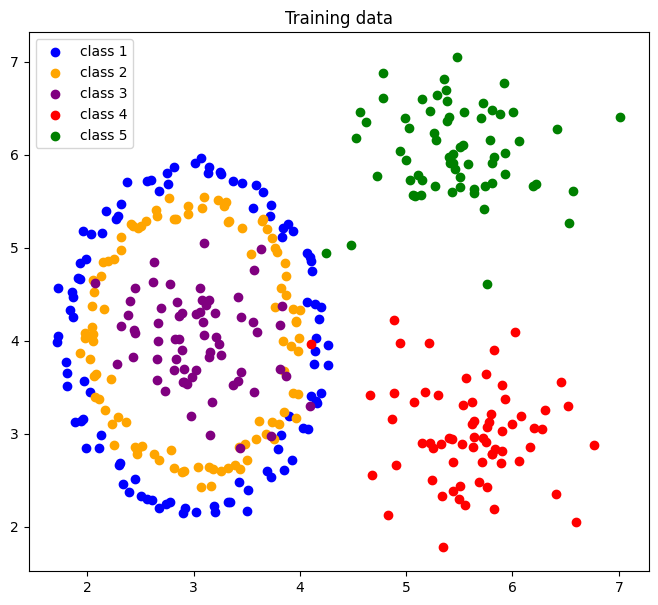

In [7]:
plt.figure(figsize=(8,7))
Colors  = ['blue', 'orange', 'purple', 'red', 'green']
for idx, cl in enumerate(['class 1', 'class 2', 'class 3', 'class 4', 'class 5']):
    plt.scatter(X_train[0,:][y_train==idx],X_train[1,:][y_train==idx], label=cl, c = Colors[idx])

plt.title('Training data')
plt.legend()
plt.show()

**Q1. Définir les fonctions d'activation et leurs dérivées : la fonction d'activation sigmoïde (`Sigmoid`, `derivative_Sigmoid`) est utilisée pour la couche cachée, tandis que la fonction softmax (`Softmax`) est utilisée pour la couche de sortie.**

In [35]:
def Sigmoid(x):
    return 1/(1+np.exp(-x))

def derivative_Sigmoid(x):
    return np.exp(-x)/((1+np.exp(-x))**2)
def Softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=0, keepdims=False)


**Q2. Créez une fonction appelée `initialisation `qui retourne un dictionnaire nommé ***parametres***. Ce dictionnaire contient les paramètres initiaux du réseau de neurones. Les paramètres sont initialisés aléatoirement suivant la loi uniforme.**

In [ ]:
def initialisation(N, P, K):
    '''
    N: Le nombre de neurones dans la couche d'entrée.
    P: Le nombre de neurones dans la couche cachée.
    K: Le nombre de neurones dans la couche de sortie.
    '''
    a = 0.5
    
    np.random.seed(10)
    W1 = np.random.uniform(-a, a, (P,N ))
    b1 = np.zeros((P,1))
    W2 = np.random.uniform(-a, a, (P ,K ))
    b2 = np.zeros((K,1))

    parametres = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }

    return parametres

parametres = initialisation(3, 2, 1)
print('W1 = \n' , parametres['W1'])
print('b1 = \n' , parametres['b1'])
print('W2 = \n' , parametres['W2'])
print('b2 = \n' , parametres['b2'])

W1 = 
 [[ 0.27132064 -0.47924805]
 [ 0.13364823  0.24880388]
 [-0.00149299 -0.27520335]]
b1 = 
 [[0.]
 [0.]]
W2 = 
 [[-0.30193714]
 [ 0.26053071]]
b2 = 
 [[0.]]


**Q3. Créez la fonction `forward_propagation` qui calcule la sortie de chaque couche du réseau de neurones. Elle prend en entrée les données **X** ainsi que les paramètres **parametres** du réseau de neurones. Cette fonction retourne le dictionnaire ***activations*** qui contient les sorties des différentes couches.**

$Z1 = W1\cdot X + b1$

$A1 = f_1(Z1)$

$Z2 = W2\cdot A1  + b2$ 

$A2 = f_2(Z2)$ 

In [33]:
def forward_propagation(X, parametres):
    
    W1 = parametres['W1']
    b1 = parametres['b1']
    W2 = parametres['W2']
    b2 = parametres['b2']

    Z1 = W1.T.dot(X)+ b1
    A1 = Sigmoid(Z1)
    Z2 = W2.dot(A1) +b2
    A2 = Softmax(Z2)

    activations = {
        'Z1': Z1,
        'A1': A1,
        'Z2': Z2,
        'A2': A2
    }

    return activations

**Q4. Implémentez une fonction `backward_propagation` prenant en argument les données d'entrée **X**, les étiquettes **y**, les paramètres actuels **parametres**, et les activations **activations**. Cette fonction retourne un dictionnaire **gradient** qui contient les gradients des paramètres.**

In [10]:
def back_propagation(X, Y, parametres, activations):
    
    Z1 = activations['Z1']
    A1 = activations['A1']
    A2 = activations['A2']
    W2 =parametres['W2']

    J = X.shape[1]

    dZ2 = A2 - Y

    dW2 = 1/J * dZ2 .dot(A1.T)
    db2 = 1/J * np.sum(dZ2, axis = 1, keepdims = True)

    dZ1 = np.multiply(np.dot(W2.T, dZ2), A1*(1-A1) )

    dW1 = 1/J * dZ1.dot(X.T)
    db1 = 1/J * np.sum(dZ1, axis = 1, keepdims = True)

    gradients = {
        'dW1' : dW1,
        'db1' : db1,
        'dW2' : dW2,
        'db2' : db2
    }

    return gradients

**Q5. Implémentez une fonction `update` qui effectue la mise à jour des paramètres en utilisant la méthode de la **descente de gradient**. Cette fonction prend en entrée les gradients calculés (**gradients**), les paramètres actuels (**parametres**), ainsi que le taux d'apprentissage (**learning_rate**). Elle soustrait le produit du taux d'apprentissage par les gradients des paramètres actuels pour obtenir les nouveaux paramètres mis à jour.**

In [12]:
def update(gradients, parametres, learning_rate):

    W1 = parametres['W1']
    b1 = parametres['b1']
    W2 = parametres['W2']
    b2 = parametres['b2']

    dW1 = gradients['dW1']
    db1 = gradients['db1']
    dW2 = gradients['dW2']
    db2 = gradients['db2']

    W1 = W1 -  learning_rate  * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parametres = {
        'W1': W1,
        'b1': b1,
        'W2': W2,
        'b2': b2
    }

    return parametres

La fonction objectif :

 $$ E(W) = - \dfrac{1}{J} \sum_{j=1}^{J} \sum_{k=1}^{K} y_k^j\times \log(\hat{y}^j_k)$$
 tels que:


*   $y^j = (y_1^j, \cdots,  y_k^j, \cdots, y_K^j)$ représente la sortie désirée pour l'exemple $x^j$
*   $ A2^j = \hat{y}^j = (\hat{y}_1^j, \cdots,  \hat{y}_k^j, \cdots, \hat{y}_K^j)$ représente la sortie calculée par le réseau pour l'exemple $x^j$.




In [13]:
def Cross_Entropy_Loss(A2, Y):
    J = Y.shape[1]
    cost = - 1/J * np.sum(Y * np.log(A2))
    return cost

def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    A2 = activations['A2']
    y_pred = np.argmax(A2, axis=0)
    return y_pred

**Q6. Implémentez la fonction `MLP_Three_Layers` qui prend comme arguments les données d'entraînement **X** et les étiquettes correspondantes **Y**, ainsi que le nombre de neurones dans la couche cachée (**Neurone_cachee**), le taux d'apprentissage (**learning_rate**), et le nombre d'itérations d'entraînement (**n_iter**).**

La fonction commence par l'initialisation des paramètres du réseau. Ensuite, elle itère sur un nombre fixé d'itérations, où à chaque itération, elle effectue une propagation avant (**forward_propagation**) pour obtenir les activations du réseau pour les données d'entrée.

Ensuite, elle effectue une propagation arrière (**back_propagation**) pour calculer les gradients des paramètres par rapport à la fonction loss. Ces gradients sont utilisés pour mettre à jour les paramètres du réseau (**parametres**) en utilisant la fonction **update**, qui utilise la méthode de descente de gradient.

La fonction retourne un dictionnaire **Metric** qui contient les listes **train_loss** et **train_acc**, ainsi que les paramètres optimaux du réseau de neurones entraînés.

In [27]:
initialisation( N = X_train.shape[0], P =12,K = Y_train.shape[0])

{'W1': array([[ 0.27132064, -0.47924805,  0.13364823,  0.24880388, -0.00149299],
        [-0.27520335, -0.30193714,  0.26053071, -0.33088916, -0.41166019],
        [ 0.18535982,  0.45339335, -0.49605173,  0.01219226,  0.31262096],
        [ 0.11252607,  0.22175532, -0.20812393,  0.41777412,  0.21457578],
        [ 0.04254437, -0.35782995, -0.12665924,  0.17413362, -0.05816683],
        [-0.06598601,  0.11776698,  0.01313824,  0.15039718,  0.10103895],
        [ 0.3052232 ,  0.02164715,  0.40864888, -0.18076391, -0.40954065],
        [-0.19929994, -0.38601564,  0.32868133, -0.45310368,  0.12628715],
        [ 0.04758616,  0.319287  , -0.30105246,  0.3568503 , -0.14834736],
        [ 0.25464769, -0.20403829,  0.38393648, -0.17448836, -0.3349841 ],
        [-0.10747076, -0.40653963,  0.32110566, -0.34884798, -0.11588555],
        [ 0.44426071,  0.48762547, -0.04369545,  0.32612284, -0.24862587]]),
 'b1': array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
  

In [24]:
def MLP_Three_Layers(X, Y, Neurone_cachee = 12, learning_rate = 0.05, n_iter = 60000):

    # Initialisation des paramètres
    N = X.shape[0]
    P = Neurone_cachee
    K = Y.shape[0]

    parametres = initialisation(N,P,K)

    train_loss = []
    train_acc = []
    for i in range(n_iter):
        activations = forward_propagation(X,parametres)
        A2 = activations['A2']

        loss = Cross_Entropy_Loss(A2, Y)
        train_loss.append(loss)

        y_pred = predict(X, parametres)
        y = np.argmax(Y, axis=0)

        acc = accuracy_score(y.flatten(), y_pred.flatten())
        train_acc.append(acc)

        gradients = back_propagation(X,Y,parametres,activations)
        parametres = update(gradients,parametres,learning_rate)

        if (i+1) % int(n_iter/20) == 0:
            print ("==> {} %   Train loss :{:,.4f} || Train Accu : {:,.4f} ".format(int(100*(i+1)/n_iter) , 
                                                                                    loss, acc))



    Metric = {
        'train_loss': train_loss,
        'train_acc': train_acc,
        'parametres': parametres,
    }

    return Metric



Entraînement du modèle

In [21]:
X_train.shape,Y_train.shape

((2, 400), (5, 400))

In [36]:

Metric = MLP_Three_Layers(X_train, Y_train, Neurone_cachee = 12, learning_rate = 0.05, n_iter = 1000)


ValueError: shapes (12,5) and (12,400) not aligned: 5 (dim 1) != 12 (dim 0)

Evolution de l'erreur et l'accuracy

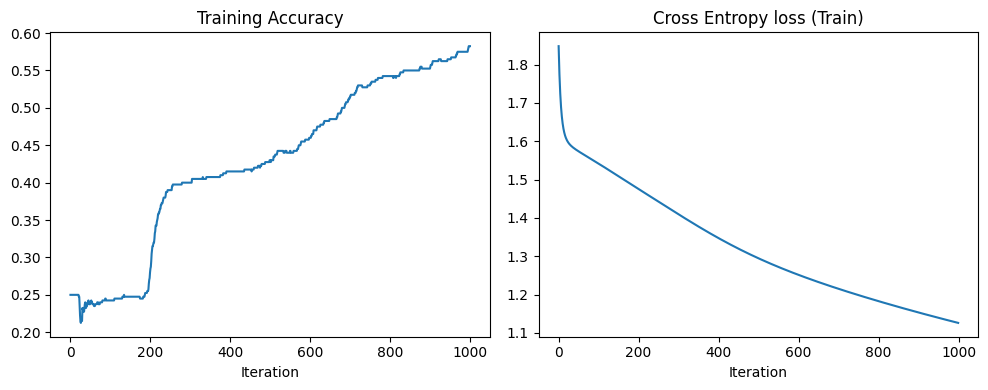

In [40]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(Metric['train_acc'])
plt.title('Training Accuracy')
plt.xlabel('Iteration')

plt.subplot(1, 2, 2)
plt.plot(Metric['train_loss'])
plt.title('Cross Entropy loss (Train)')
plt.xlabel('Iteration')

plt.tight_layout()
plt.show()


Visualisation de la solution approchée

In [ ]:
plt.figure(figsize=(10, 5))

N = 200
Colors  = ['blue', 'orange', 'purple', 'red', 'green']
extent = [1, 8 , 1 , 8]
xx, yy = np.meshgrid(np.linspace(extent[0], extent[1], N), np.linspace(extent[2], extent[3], N))
grid_points = np.c_[xx.ravel(), yy.ravel()].T

plt.subplot(1, 2, 1)

parametres = Metric['parametres']
y_predected_grid_point = predict(grid_points, parametres)
for idx, cl in enumerate(['class 1', 'class 2', 'class 3', 'class 4', 'class 5']):
    plt.scatter(grid_points[0,:][y_predected_grid_point==idx], grid_points[1,:][y_predected_grid_point==idx], label=cl, c = Colors[idx])

plt.title('Solution approchée')
plt.legend()


plt.subplot(1, 2, 2)
for idx, cl in enumerate(['class 1', 'class 2', 'class 3', 'class 4', 'class 5']):
    plt.scatter(X_train[0,:][y_train==idx],X_train[1,:][y_train==idx], label=cl, c = Colors[idx])

plt.title('Training data')
plt.legend()


plt.tight_layout()
plt.show()


Application : Le problème de classification **Iris**

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris()

Data = data.data  # Données
Target = data.target  # Étiquettes

# Accéder aux noms des caractéristiques et des classes
feature_names = data.feature_names
target_names = data.target_names

# Afficher les informations sur les données
print("Noms des caractéristiques :", data.feature_names)
print("Noms des classes :", data.target_names)
print("Taille des données :", Data.shape)
print("Taille des étiquettes :", Target.shape)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(Data, Target, test_size = 0.25 , random_state = 10)

Y_train = encoder.fit_transform(y_train.reshape(-1, 1)).T
Y_test = encoder.fit_transform(y_test.reshape(-1, 1)).T
X_train, X_test = x_train.T, x_test.T
print(f'X_train.shape = {X_train.shape}   et   Y_train.shape = {Y_train.shape}')
print(f'X_test.shape = {X_test.shape}   et   Y_test.shape = {Y_test.shape}')
